<a href="https://colab.research.google.com/github/katkorre/reannotation-robustness/blob/main/robustness_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/katkorre/reannotation-robustness.git

fatal: destination path 'reannotation-robustness' already exists and is not an empty directory.


In [ ]:
# install ktrain classifier
%%capture
! pip install ktrain
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Example train

In [ ]:
davidsonhs = pd.read_csv("/content/reannotation-robustness/train/davidson_hs_train.csv")

### Calculate max length (mean+std)

In [ ]:
# Tokenize sentences and calculate sentence length
davidsonhs['tokens'] = davidsonhs['text'].apply(word_tokenize)
davidsonhs['sentence_length'] = davidsonhs['tokens'].apply(len)

# Calculate mean and standard deviation of sentence length
mean_sentence_length = davidsonhs['sentence_length'].mean()
std_sentence_length = davidsonhs['sentence_length'].std()

print('Max length is', mean_sentence_length + std_sentence_length)

Max length is 29.35009262148089


In [ ]:
model_name = "bert"
train, test = train_test_split(davidsonhs, test_size=0.1)
train, val = train_test_split(train, test_size=test.shape[0])
train_, val_, preproc = ktrain.text.texts_from_df(train, "text", "toxic", val, maxlen=30, preprocess_mode=model_name)
model = text.text_classifier(model_name, train_, preproc=preproc)
learner = ktrain.get_learner(model, train_data=train_, val_data=val_) # 32 batch_size

['not_toxic', 'toxic']
      not_toxic  toxic
1691        0.0    1.0
1663        0.0    1.0
2303        0.0    1.0
504         1.0    0.0
2121        0.0    1.0
['not_toxic', 'toxic']
      not_toxic  toxic
393         1.0    0.0
212         1.0    0.0
1281        1.0    0.0
1046        1.0    0.0
1982        0.0    1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 30


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
67/67 [==============================] - 41s 207ms/step - loss: 1.0286 - accuracy: 0.4920
Epoch 2/1024
67/67 [==============================] - 14s 210ms/step - loss: 0.9262 - accuracy: 0.4910
Epoch 3/1024
67/67 [==============================] - 14s 213ms/step - loss: 0.7581 - accuracy: 0.5160
Epoch 4/1024
67/67 [==============================] - 14s 216ms/step - loss: 0.6440 - accuracy: 0.6340
Epoch 5/1024
67/67 [==============================] - 15s 220ms/step - loss: 0.5687 - accuracy: 0.7264
Epoch 6/1024
67/67 [==============================] - 15s 223ms/step - loss: 0.4497 - accuracy: 0.8024
Epoch 7/1024
67/67 [==============================] - 15s 227ms/step - loss: 0.3076 - accuracy: 0.8840
Epoch 8/1024
67/67 [==============================] - 15s 225ms/step - loss: 0.1994 - accuracy: 0.9278
Epoch 9/1024
67/67 [==============================] - 15s 222ms/step - loss: 0.1783 - accurac

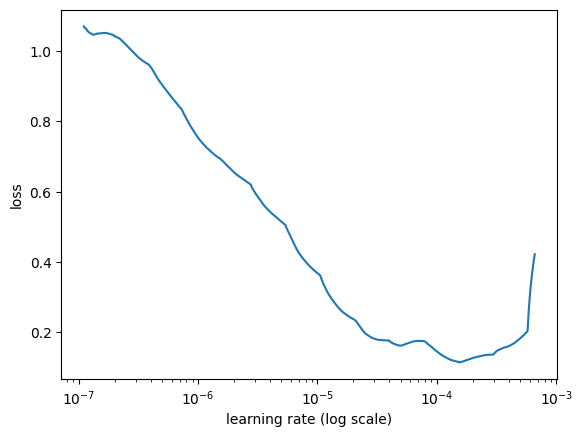

In [ ]:
learner.lr_plot()

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
67/67 [==============================] - 45s 333ms/step - loss: 0.4985 - accuracy: 0.7509 - val_loss: 0.2595 - val_accuracy: 0.9019
Epoch 2/1024
67/67 [==============================] - 16s 236ms/step - loss: 0.2321 - accuracy: 0.9071 - val_loss: 0.3200 - val_accuracy: 0.8755
Epoch 3/1024
67/67 [==============================] - 16s 244ms/step - loss: 0.1147 - accuracy: 0.9608 - val_loss: 0.1347 - val_accuracy: 0.9321
Epoch 4/1024
67/67 [==============================] - 16s 233ms/step - loss: 0.0633 - accuracy: 0.9816 - val_loss: 0.1557 - val_accuracy: 0.9396
Epoch 5/1024
67/67 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9906
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
67/67 [==============================] - 16s 232

In [ ]:
p = ktrain.get_predictor(learner.model, preproc)

## Test on Toxicity

In [ ]:
test = pd.read_csv("/content/reannotation-robustness/test/test_tox.csv")

In [ ]:
test['preds']=test.apply(lambda row: p.predict(row['text']), axis=1)

In [ ]:
test

,Unnamed: 0,gold_toxicity,toxicity,source,text,max,preds
0,0,NaN,"[1, 0, 0, 1, 1]",C,and we shud also destroy taj mahal... qutub mi...,1,not_toxic
1,1,NaN,"[1, 0, 1, 1, 1]",B,Project pay is just a soft ass little bitch.,1,toxic
2,2,NaN,"[1, 1, 1, 0, 1]",A,@tiffantasticc your dad is genuine happy guy b...,1,toxic
3,3,NaN,"[1, 0, 0, 0, 1]",C,Now India will start striking back through Twi...,0,toxic
4,4,NaN,"[0, 0, 0, 1, 1]",A,Early bird gets the worm! &#128027;&#128036;,0,not_toxic
...,...,...,...,...,...,...,...
595,595,YES,"[1, 1, 1, 1, 1]",B,"""@Frosstyy_: @h0rheyd I didn't say anything th...",1,toxic
596,596,NO,"[1, 1, 0, 0, 0]",C,Launch veiled attack? This is what a democrati...,0,toxic
597,597,YES,"[0, 1, 0, 0, 1]",A,"&#8220;@MikeyPDaCav5: I love the song ""John Do...",0,not_toxic
598,598,YES,"[0, 0, 0, 0, 0]",C,In tamilnadu 76% reservation is present..whats...,0,not_toxic


In [ ]:
# map values
test['preds'] = test['preds'].map({'toxic': 1, 'not_toxic': 0})

In [ ]:
print(classification_report(test['max'], test['preds']))

              precision    recall  f1-score   support

           0       0.86      0.57      0.69       387
           1       0.51      0.83      0.63       213

    accuracy                           0.66       600
   macro avg       0.69      0.70      0.66       600
weighted avg       0.74      0.66      0.67       600

